<a href="https://colab.research.google.com/github/ayyucedemirbas/paligemma/blob/main/SigLIP_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SigLIP & CLIP from Scratch

This notebook is adopted from this Kaggle notebook: https://www.kaggle.com/code/awsaf49/siglip-clip-from-scratch

In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"username","key":"key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [2]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
100% 1.04G/1.04G [00:53<00:00, 22.4MB/s]
100% 1.04G/1.04G [00:53<00:00, 20.9MB/s]


In [11]:
import kagglehub

# Download latest version
path = kagglehub.model_download("keras/distil_bert/keras/distil_bert_base_en")

print("Path to model files:", path)

100%|██████████| 231M/231M [00:11<00:00, 20.3MB/s]
Extracting model files...


Path to model files: /root/.cache/kagglehub/models/keras/distil_bert/keras/distil_bert_base_en/2


In [12]:
import kagglehub

# Download latest version
path = kagglehub.model_download("keras/efficientnetv2/keras/efficientnetv2_b2_imagenet_classifier")

print("Path to model files:", path)

100%|██████████| 36.2M/36.2M [00:02<00:00, 13.9MB/s]
Extracting model files...


Path to model files: /root/.cache/kagglehub/models/keras/efficientnetv2/keras/efficientnetv2_b2_imagenet_classifier/2


In [14]:
!mv /root/.cache/kagglehub/models/keras/efficientnetv2 .

In [15]:
!mv /root/.cache/kagglehub/models/keras/distil_bert .

In [10]:
!unzip -qq flickr8k.zip

In [6]:
!pip install -qU keras-cv keras-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 102.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 84.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 32.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch" # you can also use tensorflow or torch

import keras_cv
import keras_nlp
import keras
from keras import ops
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [2]:
image_path = "Images"
batch_size = 32
epochs = 10

# For embedding head
embedding_dim = 256
dropout = 0.1

In [4]:
df = pd.read_csv("captions.txt")
df["image_path"] = image_path + "/" + df.image
df.head()

,image,caption,image_path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,Images/1000268201_693b08cb0e.jpg
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,Images/1000268201_693b08cb0e.jpg
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,Images/1000268201_693b08cb0e.jpg
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,Images/1000268201_693b08cb0e.jpg
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,Images/1000268201_693b08cb0e.jpg


In [5]:
from sklearn.model_selection import GroupKFold

# Create a GroupKFold object with 5 folds
gkf = GroupKFold(n_splits=5)

# Add fold column based on groups
df['fold'] = -1
for fold, (train_index, valid_index) in enumerate(gkf.split(df, groups=df["image"])):
    df.loc[valid_index, 'fold'] = fold

In [6]:
# Text Encoder
text_preset = "/content/distil_bert/keras/distil_bert_base_en/2"
sequence_length = 200

In [7]:
image_size = [224, 224]

In [8]:
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    preset=text_preset, # Name of the model
    sequence_length=sequence_length, # Max sequence length, will be padded if shorter
)

def build_augmenter():
    # Define augmentations
    aug_layers = [
        keras_cv.layers.RandomBrightness(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomContrast(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomSaturation(factor=(0.45, 0.55)),
        keras_cv.layers.RandomHue(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.15), width_factor=(0.06, 0.15)),
        keras_cv.layers.RandomFlip(mode="horizontal"),
        keras_cv.layers.RandomZoom(height_factor=(0.05, 0.10)),
        keras_cv.layers.RandomRotation(factor=(0.01, 0.05)),
    ]

    # Apply augmentations to random samples
    aug_layers = [keras_cv.layers.RandomApply(x, rate=0.5) for x in aug_layers]

    # Build augmentation layer
    augmenter = keras_cv.layers.Augmenter(aug_layers)

    # Apply augmentations
    def augment(inp):
        inp["images"] = augmenter({"images": inp["images"]})["images"]
        return inp
    return augment

def build_decoder(target_size=image_size):
    def decode_image(image_path):
        # Read jpeg image
        file_bytes = tf.io.read_file(image_path)
        image = tf.io.decode_jpeg(file_bytes)

        # Resize
        image = tf.image.resize(image, size=target_size, method="area")

        # Rescale image
        image = tf.cast(image, tf.float32)
        image /= 255.0

        # Reshape
        image = tf.reshape(image, [*target_size, 3])
        return image

    def decode_text(text):
        text = preprocessor(text)
        return text

    def decode_input(image_path, text):
        image = decode_image(image_path)
        text = decode_text(text)
        return {"images":image, "texts":text}

    return decode_input


def build_dataset(
    image_paths,
    texts,
    batch_size=32,
    cache=True,
    decode_fn=None,
    augment_fn=None,
    augment=False,
    repeat=True,
    shuffle=1024,
    cache_dir="",
    drop_remainder=True,
):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder()

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE

    slices = (image_paths, texts)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle:
        ds = ds.shuffle(shuffle)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

In [9]:
# Sample from full data
sample_df = df.groupby("image").head(1).reset_index(drop=True) # .sample(frac=1.0)
train_df = sample_df[sample_df.fold != 0]
valid_df = sample_df[sample_df.fold == 0]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Train
train_paths = train_df.image_path.values
train_texts = train_df.caption.values
train_ds = build_dataset(train_paths, train_texts,
                         batch_size=batch_size,
                         repeat=True, shuffle=True, augment=True, cache=True)

# Valid
valid_paths = valid_df.image_path.values
valid_texts = valid_df.caption.values
valid_ds = build_dataset(valid_paths, valid_texts,
                         batch_size=batch_size,
                         repeat=False, shuffle=False, augment=False, cache=True)

# Num Train: 6472 | Num Valid: 1619


In [10]:
batch = next(iter(train_ds))
imgs = batch["images"]
txts = batch["texts"]

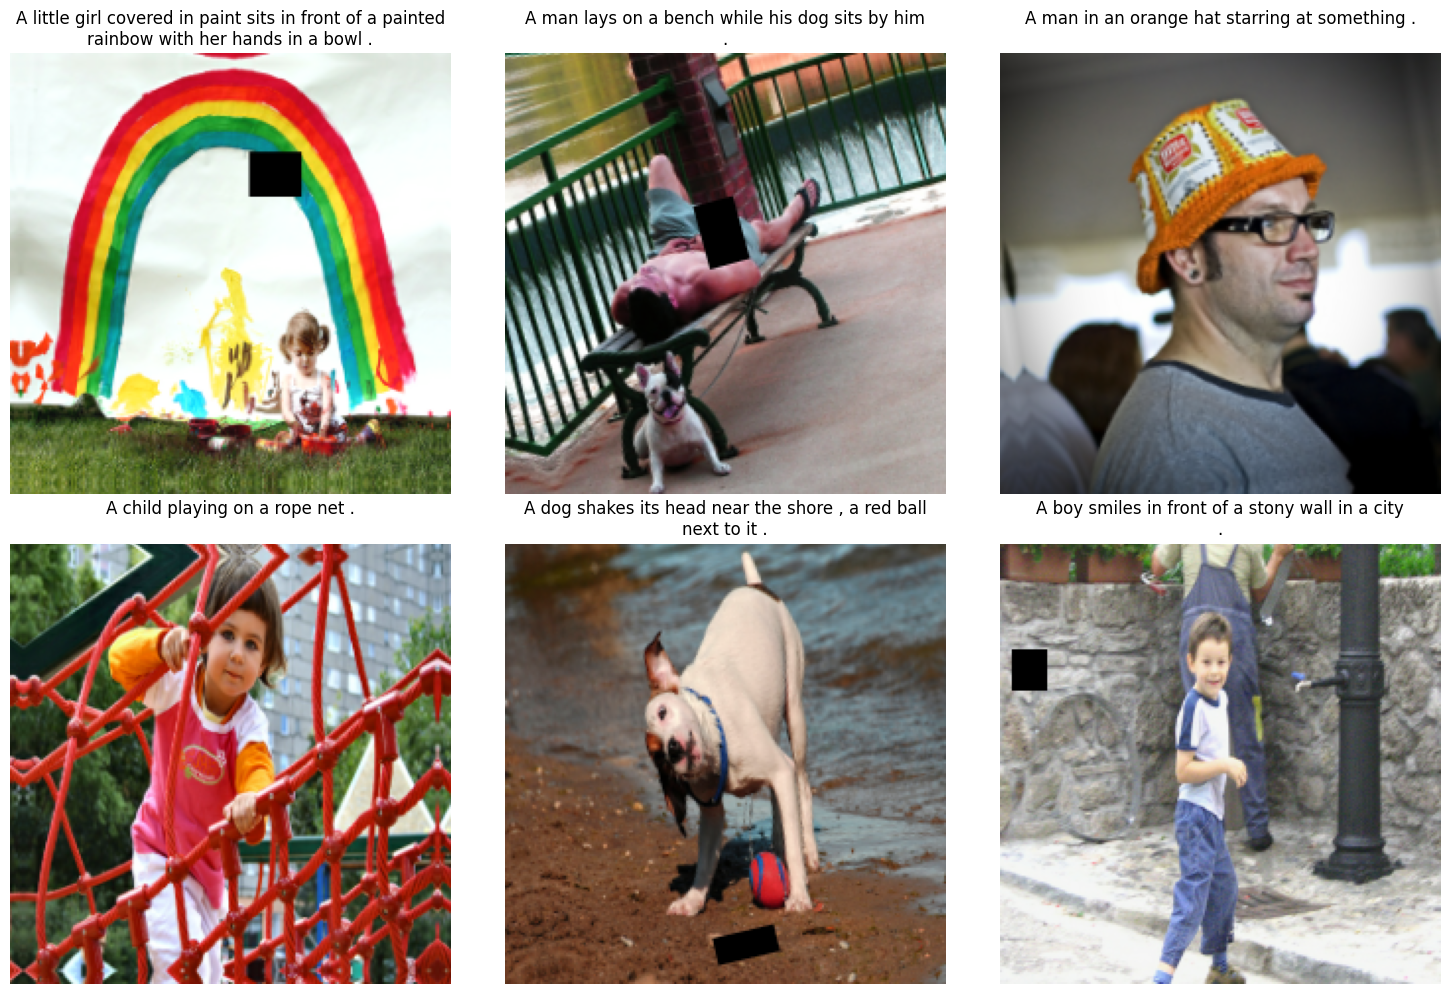

In [26]:
fig = plt.figure(figsize=(15, 10))
for i in range(6):
    img = imgs[i].numpy()
    caption = preprocessor.tokenizer.detokenize(txts["token_ids"][i]).numpy().decode("utf-8")
    caption = caption.replace("[PAD]","").replace("[CLS]","").replace("[SEP]","").strip()
    caption = " ".join(caption.split(" ")[:12]) + "\n" + " ".join(caption.split(" ")[12:])
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=12)

plt.tight_layout()
plt.show()

In [11]:
class SigLIPLoss(keras.losses.Loss):
    def __init__(self, name="siglip_loss"):
        """Calculates the SigLIP loss.

        Standard sigmoid computes the loss twice, once assuming positive
        labels and once assuming negative ones. But in this case, positives
        are on the "me" diagonal and negatives are elsewhere. So, we only
        compute the loss for each once.

        Call Args:
            y_true: Ground truth labels.
            y_pred: Predicted logits.

        Returns:
            tensor: The SigLIP loss.
        """
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        # Normalize by the number of positives per column (npos), which is one.
        # Since it's one, we just sum.
        loss = -ops.sum(ops.log_sigmoid(y_true * y_pred), axis=-1)

        # NOTE: This is equivalent to concatenating "me" and "ot" along axis -1 above.
        loss = ops.mean(loss)
        return loss


class CLIPLoss(keras.losses.Loss):
    def __init__(self, name="clip_loss"):
        """Calculates the CLIP loss.

        Call Args:
            y_true: Ground truth labels.
            y_pred: Predicted logits.

        Returns:
            tensor: The CLIP loss.
        """
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        text_loss = self.cross_entropy(y_true, y_pred)
        image_loss = self.cross_entropy(ops.transpose(y_true), ops.transpose(y_pred))
        loss =  (image_loss + text_loss) / 2.0
        loss = ops.mean(loss)
        return loss

    def cross_entropy(self, y_true, y_pred):
        loss = ops.sum(-y_true * ops.log_softmax(y_pred, axis=-1), axis=-1)
        return loss

In [12]:
class ProjectionHead(keras.Model):
    def __init__(
        self,
        embedding_dim=embedding_dim,
        dropout=dropout
    ):
        super().__init__()
        self.projection = keras.layers.Dense(embedding_dim)
        self.gelu = keras.layers.Activation("gelu")
        self.fc = keras.layers.Dense(embedding_dim)
        self.dropout = keras.layers.Dropout(dropout)
        self.layer_norm = keras.layers.LayerNormalization()

    def call(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [13]:
# Image Encoder
image_preset = "efficientnetv2/keras/efficientnetv2_b2_imagenet_classifier/2"

In [14]:
def build_image_encoder():
    backbone = keras_cv.models.ImageClassifier.from_preset(
        image_preset,
    )
    out = backbone.layers[-2].output
    out = ProjectionHead()(out)
    model = keras.models.Model(backbone.input, out)
    return model

In [15]:
image_encoder = build_image_encoder()
image_encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficient_net_v2_backbone_1          │ (None, None, None, 1408)    │       8,769,374 │
│ (EfficientNetV2Backbone)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool (GlobalAveragePooling2D)    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ projection_head (ProjectionHead)     │ (None, 256)                 │         427,008 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,196,382 (35.08 MB)

 Trainable params: 9,114,094 (34.77 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [16]:
def build_text_encoder():
    backbone = keras_nlp.models.DistilBertClassifier.from_preset(
        text_preset,
        num_classes=1
    )
    out = backbone.layers[-3].output
    out = ProjectionHead()(out)
    model = keras.models.Model(backbone.input, out)
    return model

In [17]:
text_encoder = build_text_encoder()
text_encoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer) │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_ids (InputLayer)    │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ distil_bert_backbone      │ (None, None, 768)      │     65,190,912 │ padding_mask[0][0],    │
│ (DistilBertBackbone)      │                        │                │ token_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 768)            │              0 │ distil_bert_backbone[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pooled_dense (Dense)      │ (None, 768)            │        590,592 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ projection_head_1         │ (None, 256)            │        263,168 │ pooled_dense[0][0]     │
│ (ProjectionHead)          │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 66,044,672 (251.94 MB)

 Trainable params: 66,044,672 (251.94 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
class SigLIPModel(keras.Model):
    def __init__(
        self,
        image_encoder,
        text_encoder,
        num_logits,
        logit_scale,
        logit_bias,
    ):
        super().__init__()
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.num_logits = num_logits
        self.logit_scale = logit_scale
        self.logit_bias = logit_bias

    def compile(
        self,
        optimizer,
        loss,
    ):
        super().compile(optimizer=optimizer)
        self.loss = loss

    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
        logits = self.get_logits(x, training=True)
        labels = self.get_ground_truth(self.num_logits)
        return self.loss(labels, logits)

    def get_ground_truth(self, num_logits):
        labels = -ops.ones((num_logits, num_logits))
        labels = labels + 2 * ops.eye(num_logits)
        labels = ops.cast(labels, dtype="float32")
        return labels

    def get_logits(self, x, training):
        image_features = self.image_encoder(x["images"], training=training)
        text_features = self.text_encoder(x["texts"], training=training)
        logits = image_features @ ops.transpose(text_features)
        logits = self.logit_scale * logits + self.logit_bias
        logits = ops.cast(logits, dtype="float32")
        return logits

    def build(self, input_shape):
        super().build(input_shape)
        self.built = True

    def call(self, x, training=False):
        return self.get_logits(x, training=training)

In [19]:
model = SigLIPModel(image_encoder, text_encoder, num_logits=batch_size,
                    logit_scale=2.30, logit_bias=-10.0)

model.compile(optimizer="adam", loss=SigLIPLoss())

In [39]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 3e-5, 5e-6 * batch_size, 3e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

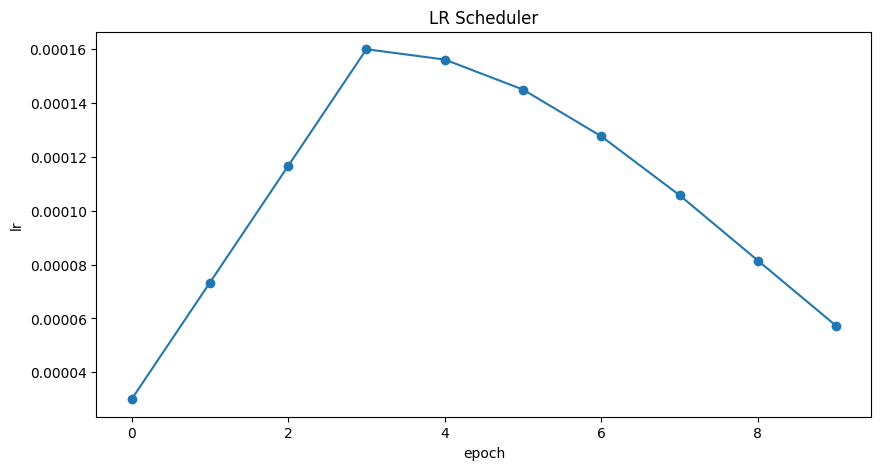

In [40]:
lr_cb = get_lr_callback(batch_size, mode="cos", plot=True)

In [20]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.keras",
                                         monitor='val_loss',
                                         save_best_only=True,
                                         save_weights_only=False,
                                         mode='min')

In [ ]:
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[ckpt_cb],
    steps_per_epoch=len(train_df) // batch_size,
    validation_data=valid_ds,
    verbose=1,
)

Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 133.5926

In [ ]:
model.load_weights("best_model.keras")

In [ ]:
class CLIPModel(keras.Model):
    def __init__(self, image_encoder, text_encoder, temperature=1.0):
        super().__init__()
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.temperature = temperature

    def compile(
        self,
        optimizer,
        loss,
    ):
        super().compile(optimizer=optimizer)
        self.loss = loss

    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
        image_features, text_features = self.get_features(x, training=True)
        logits = self.get_logits(image_features, text_features)
        labels = self.get_ground_truth(image_features, text_features)
        return self.loss(labels, logits)

    def get_features(self, x, training):
        image_features = self.image_encoder(x["images"], training=training)
        text_features = self.text_encoder(x["texts"], training=training)
        return image_features, text_features

    def get_ground_truth(self, image_features, text_features):
        image_scores = image_features @ ops.transpose(image_features)
        text_scores = text_features @ ops.transpose(text_features)
        labels = ops.softmax(
            (image_scores + text_scores) / 2 * self.temperature, axis=-1
        )
        labels = ops.cast(labels, dtype="float32")
        return labels

    def get_logits(self, image_features, text_features, logit_scale=1.0):
        logits = image_features @ ops.transpose(text_features) / self.temperature
        logits = ops.cast(logits, dtype="float32")
        return logits

    def build(self, input_shape):
        super().build(input_shape)
        self.built = True

    def call(self, x, training=False):
        image_features, text_features = self.get_features(x, training=training)
        logits = self.get_logits(image_features, text_features)
        return logits

In [ ]:
CLIP_model = CLIPModel(image_encoder, text_encoder)
CLIP_model.compile(optimizer="adam", loss=CLIPLoss())

In [ ]:
history = CLIP_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[lr_cb, ckpt_cb],
    steps_per_epoch=len(train_df) // batch_size,
    validation_data=valid_ds,
    verbose=1,
)

##Zero-Shot Classification

In [ ]:
def process_image(path):
    img = cv2.imread(path)[...,::-1] # BGR -> RGB
    img = cv2.resize(img, dsize=image_size, interpolation=cv2.INTER_AREA)
    img = img / 255.0
    return img

def process_text(text):
    text = [f"a photo of a {x}" for x in text]
    return preprocessor(text)

def zero_shot_classifier(image_path, candid_labels):
    image = process_image(image_path)
    plt.imshow(image)
    image = ops.convert_to_tensor(image)[None,]
    text = process_text(candid_labels)
    pred = model({"images":image, "texts":text})
    pred = ops.softmax(pred)*100
    pred = ops.convert_to_numpy(pred).tolist()[0]
    pred = dict(zip(candid_labels, np.round(pred, 2)))
    plt.title(f"Prediction: {pred}", fontsize=10)
    plt.show()
    return pred

In [ ]:
!wget "https://img.freepik.com/free-psd/banana-character-isolated_23-2151170924.jpg" -O "banana.jpg"

In [ ]:
pred = zero_shot_classifier(image_path="banana.jpg",
                            candid_labels=["banana", "man", "dog"])